# Boolean Network Analysis Workflow Example
This notebook demonstrate the workflow to simulate, extend and analyze a Boolean network through Probabilistic Boolean Network (PBN) approach.

In [1]:
import sys
sys.path.append('./src')
import BNMPy
import Optimizer

## Load a Boolean Network

Below is a synthetic model that describes the EGFR-RAS-MAPK pathway, and the DNA-damage–p53 apoptotic checkpoint.


In [2]:
network_string = """
EGF = EGF
EGFR = EGF
DNA_DAMAGE  = DNA_DAMAGE
KRAS   = EGFR
RAF1   = KRAS
MAP2K1 = RAF1
MAPK1  = MAP2K1
PIK3CA = EGFR | MAPK1
PTEN   = !PIK3CA
AKT1   = PIK3CA & !PTEN
MDM2   = AKT1
TP53   = DNA_DAMAGE & !MDM2
CASP3  = TP53 & !AKT1
CDK2   = (MAPK1 | AKT1) & !TP53
"""
network = BNMPy.load_network_from_string(network_string)

No initial state provided, using a random initial state
Network loaded successfully. There are 14 genes in the network.


An example of experimental data is provided in `files/experiments_example.csv`.  
It includes the experimental conditions like stimulate EGFR and inhibit PDPK1, and the measured values of the output nodes.

In [3]:
data_example_file = 'files/experiments_example.csv'
measured_nodes, perturbed_nodes = Optimizer.extract_experiment_nodes(data_example_file)

   Extracted 5 measured nodes: {'CDK2', 'TP53', 'MAPK1', 'CASP3', 'AKT1'}
   Extracted 6 perturbed nodes: {'MAP2K1', 'EGF', 'PDPK1', 'PIK3CA', 'MDM2', 'DNA_DAMAGE'}


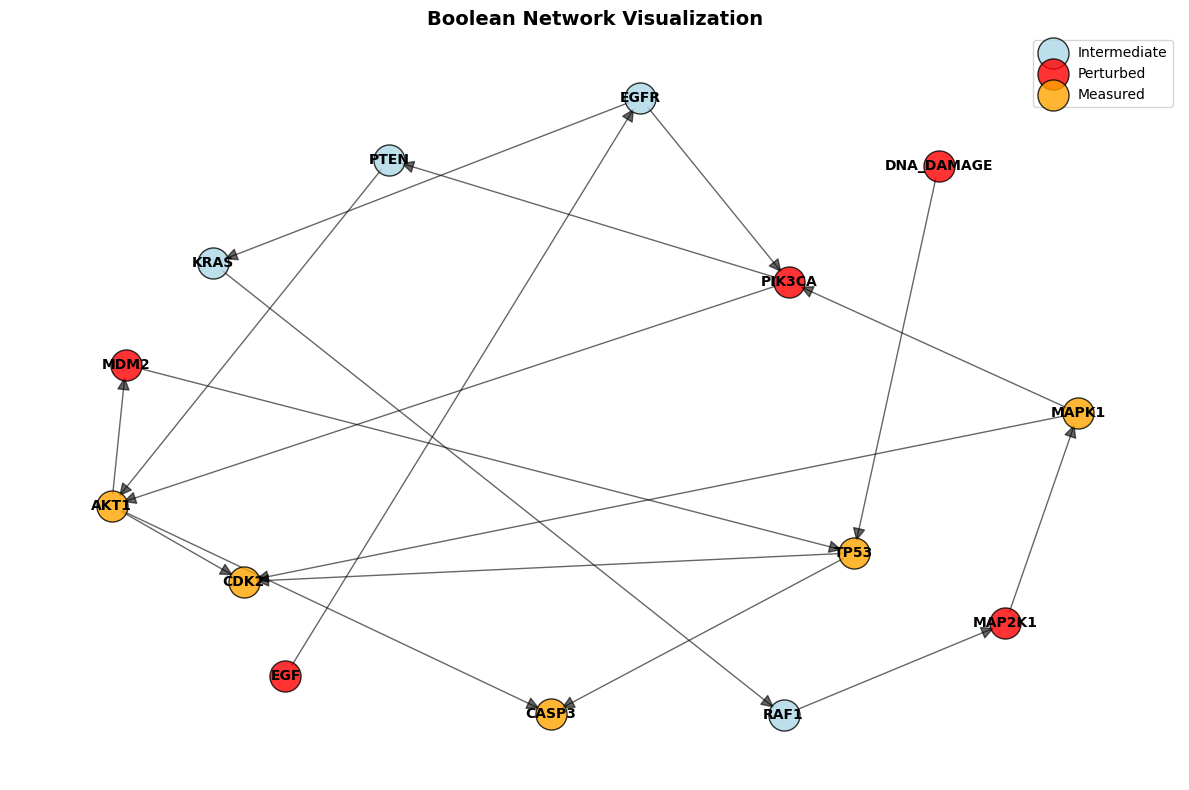

In [4]:
BNMPy.vis_network(network, measured_nodes=measured_nodes, perturbed_nodes=perturbed_nodes)

In [5]:
# Alternatively, an interactive visualization
BNMPy.vis_network(network, output_html="files/ExampleBN.html", interactive=True, measured_nodes=measured_nodes, perturbed_nodes=perturbed_nodes)

Network visualization saved to files/ExampleBN.html


## Compress the network

Before simulation, we can simplify the network by:
1. Removing non-observable nodes: 
2. Removing non-controllable nodes
3. Collapsing linear paths

This is because these nodes and edges do not affect the dynamics of the network for the given experiments, and we could simplify the network for better efficiency.

In [4]:
compressed_network, compression_info = Optimizer.compress_model(
    network,
    measured_nodes=measured_nodes,
    perturbed_nodes=perturbed_nodes
)

Model Compression Summary:
  Measured nodes: AKT1, CASP3, CDK2, MAPK1, TP53
  Perturbed nodes: DNA_DAMAGE, EGF, MAP2K1, MDM2, PDPK1, PIK3CA

Removed 0 non-observable nodes
Removed 0 non-controllable nodes
Collapsed 1 linear paths
  Path 1: KRAS -> RAF1 -> MAP2K1

Total nodes removed/collapsed: 2
Final network size: 12 nodes


In [5]:
compressed_network_string = '\n'.join(compressed_network.equations)
print("=========Compressed Network=========")
print(compressed_network_string)

=========Compressed Network=========
EGF = EGF
EGFR = EGF
DNA_DAMAGE  = DNA_DAMAGE
MAP2K1 = EGFR
MAPK1  = MAP2K1
PIK3CA = EGFR | MAPK1
PTEN   = !PIK3CA
AKT1   = PIK3CA & !PTEN
MDM2   = AKT1
TP53   = DNA_DAMAGE & !MDM2
CASP3  = TP53 & !AKT1
CDK2   = (MAPK1 | AKT1) & !TP53


In [6]:
# visualize the compression difference
BNMPy.vis_compression(
    network,
    compressed_network, 
    compression_info,
    output_html="files/compression.html",
    interactive=True
)

Network visualization saved to files/compression.html


## Standardize the network

Before extending the network using knowledge graph, we need to standardize the gene names to find a match in the knowledge graph.


## Extend the network

Because the input model may not cover the genes we want to analyze, e.g., missing regulators or drug targets, we can extend the network using the knowledge graph (KG).  

Here, assume that we want to add `PDPK1` to the network to evaluate its inhibition effect.

**Approach of KG extension**:  
Given a list of genes of interest:

1. Find the Steiner subgraph for the given list of genes.
2. For each node in the subgraph, find all if its input nodes (i.e. all edges leading into that node).
3. For each such node, there is an activating relation if the edge is "up-regulates", and a repressing relation if the edge is "down-regulates".
4. Combine all of the edges with a "joiner function" - AND, OR, inhibitor wins, etc.
(Threshold value, majority voting, etc?)

In [7]:
# First we need to specify the genes to be considered
# we will first get the genes from the compressed network
genes = compressed_network.nodeDict.keys()
# then we can add the genes of interest to the list
genes_of_interest = ['PDPK1']
genes = list(set(genes).union(set(genes_of_interest)))
print(genes)

['PIK3CA', 'DNA_DAMAGE', 'PTEN', 'EGF', 'PDPK1', 'CDK2', 'CASP3', 'MAPK1', 'EGFR', 'AKT1', 'TP53', 'MDM2', 'MAP2K1']


In [8]:
# get the knowledge graph-derived network
KG_string, relations = BNMPy.load_signor_network(genes, joiner='inhibitor_wins')
print("\n")
print("=========Knowledge Graph Network=========")
print(KG_string)

number of genes found: 12
[5290, 5728, 1950, 5170, 1017, 836, 5594, 1956, 207, 7157, 4193, 5604]


=========Knowledge Graph Network=========
AKT1 = (!PTEN & !CASP3) & (PDPK1 | PIK3CA)
CASP3 = CASP3
CDK2 = (AKT1 | MAPK1 | CDK2)
EGF = EGF
EGFR = !MAPK1 & (EGFR | TP53 | EGF)
MAP2K1 = !MAPK1 & (PDPK1 | MAP2K1)
MAPK1 = (MAPK1 | MAP2K1)
MDM2 = (AKT1 | TP53)
PDPK1 = PDPK1
PIK3CA = !PTEN
PTEN = PTEN
TP53 = !MDM2 & CDK2


**We can now merge the knowledge graph network with the compressed network.**   
  
There are four different ways to merge the networks:

1. AND
2. OR
3. Inhibitor Wins
4. PBN

For details, please refer to [LM-Merger](https://doi.org/10.1186/s12859-025-06212-2).

In [9]:
KG = BNMPy.load_network_from_string(KG_string)
# Merge the networks using inhibitor wins
extended_network_string = BNMPy.merge_networks([compressed_network, KG], method="Inhibitor Wins", descriptive=True)

No initial state provided, using a random initial state
Network loaded successfully. There are 12 genes in the network.
Merging Method: Inhibitor Wins
Total Genes in Merged Network: 13
Number of Genes in Each Individual Model:
  Model 1: 12 genes
  Model 2: 12 genes
Overlapping Genes: 11
Overlapping Genes List: AKT1, CASP3, CDK2, EGF, EGFR, MAP2K1, MAPK1, MDM2, PIK3CA, PTEN, TP53

Gene: AKT1
  Model 1 Function: PIK3CA & !PTEN
  Model 2 Function: !CASP3 & !PTEN & ( PDPK1 | PIK3CA )
  Merged Function: !CASP3 & !PTEN & ( PDPK1 | PIK3CA )

Gene: CASP3
  Model 1 Function: !AKT1 & TP53
  Model 2 Function: CASP3
  Merged Function: !AKT1 & ( CASP3 | TP53 )

Gene: CDK2
  Model 1 Function: !TP53 & ( AKT1 | MAPK1 )
  Model 2 Function: AKT1 | CDK2 | MAPK1
  Merged Function: !TP53 & ( AKT1 | CDK2 | MAPK1 )

Gene: EGF
  Model 1 Function: EGF
  Model 2 Function: EGF
  Merged Function: EGF

Gene: EGFR
  Model 1 Function: EGF
  Model 2 Function: !MAPK1 & ( EGF | EGFR | TP53 )
  Merged Function: !MAPK1 

In [10]:
# Merge the networks using PBN
# Here, a probability of 0.9 is used for rules from the original network
pbn_string = BNMPy.merge_networks([compressed_network, KG], method="PBN", prob=0.9)
print("=========Merged PBN=========")
print(pbn_string)

=========Merged PBN=========
AKT1 = !CASP3 & !PTEN & ( PDPK1 | PIK3CA ), 0.1
AKT1 = PIK3CA & !PTEN, 0.9
CASP3 = !AKT1 & TP53, 0.9
CASP3 = CASP3, 0.1
CDK2 = !TP53 & ( AKT1 | MAPK1 ), 0.9
CDK2 = AKT1 | CDK2 | MAPK1, 0.1
DNA_DAMAGE = DNA_DAMAGE, 1.0
EGF = EGF, 0.9
EGFR = !MAPK1 & ( EGF | EGFR | TP53 ), 0.1
EGFR = EGF, 0.9
MAP2K1 = !MAPK1 & ( MAP2K1 | PDPK1 ), 0.1
MAP2K1 = EGFR, 0.9
MAPK1 = MAP2K1 | MAPK1, 0.1
MAPK1 = MAP2K1, 0.9
MDM2 = AKT1 | TP53, 0.1
MDM2 = AKT1, 0.9
PDPK1 = PDPK1, 1.0
PIK3CA = !PTEN, 0.1
PIK3CA = EGFR | MAPK1, 0.9
PTEN = !PIK3CA, 0.9
PTEN = PTEN, 0.1
TP53 = CDK2 & !MDM2, 0.1
TP53 = DNA_DAMAGE & !MDM2, 0.9


Alternatively, instead of merging the two networks with all the rules, we can just extend the network with several new rules from the knowledge graph.   
This can be done through the `extend_networks` function: 

`extend_networks(original_network, new_network, nodes_to_extend, prob=0.5, descriptive=True)`

This will return a PBN where:
 - rules for the nodes_to_extend are added to the original network with a probability of prob.
 - rules for the nodes_to_extend from the original network will have a probability of 1-prob.
   - in case the new rules for nodes_to_extend include new nodes, they will also be added with a probability of 1.
   - The direct targets of nodes_to_extend are also extended with both rules and probabilities.
 - The rest of the rules are kept the same with a probability of 1.

In [11]:
# Extend the network using PBN
extended_network_string = BNMPy.extend_networks(compressed_network, KG, ['PDPK1'], prob=0.5)
print("\n")
print("=========Extended PBN=========")
print(extended_network_string)

Nodes affected: ['AKT1', 'MAP2K1', 'PDPK1']

Gene: AKT1
  Original rule: PIK3CA & !PTEN
  Added rule: !CASP3 & !PTEN & ( PDPK1 | PIK3CA ), 0.5

Gene: MAP2K1
  Original rule: EGFR
  Added rule: !MAPK1 & ( MAP2K1 | PDPK1 ), 0.5

Gene: PDPK1
  Not present in original network
  Added rule: PDPK1, 1


=========Extended PBN=========
AKT1 = !CASP3 & !PTEN & ( PDPK1 | PIK3CA ), 0.5
AKT1 = PIK3CA & !PTEN, 0.5
CASP3 = !AKT1 & TP53, 1.0
CDK2 = !TP53 & ( AKT1 | MAPK1 ), 1.0
DNA_DAMAGE = DNA_DAMAGE, 1.0
EGF = EGF, 1.0
EGFR = EGF, 1.0
MAP2K1 = !MAPK1 & ( MAP2K1 | PDPK1 ), 0.5
MAP2K1 = EGFR, 0.5
MAPK1 = MAP2K1, 1.0
MDM2 = AKT1, 1.0
PDPK1 = PDPK1, 1.0
PIK3CA = EGFR | MAPK1, 1.0
PTEN = !PIK3CA, 1.0
TP53 = DNA_DAMAGE & !MDM2, 1.0


In [13]:
pbn = BNMPy.load_pbn_from_string(extended_network_string)
BNMPy.vis_network(pbn, output_html="files/ExtendedPBN.html", interactive=True, measured_nodes=measured_nodes, perturbed_nodes=perturbed_nodes)

No initial state provided, using a random initial state
PBN loaded successfully. There are 13 genes in the network.
Network visualization saved to files/ExtendedPBN.html


## Optimize the network

We can now optimize the network using the experimental data by finding the best probabilities for each rule.  
This is done by minimizing the difference (MSE) between the predicted and experimental values of the output nodes in steady state.  

### Test for convergence

Before running the optimization, we can test how many Monte Carlo steps are needed to achieve a steady state. This can then be used to set the configuration for the optimization.

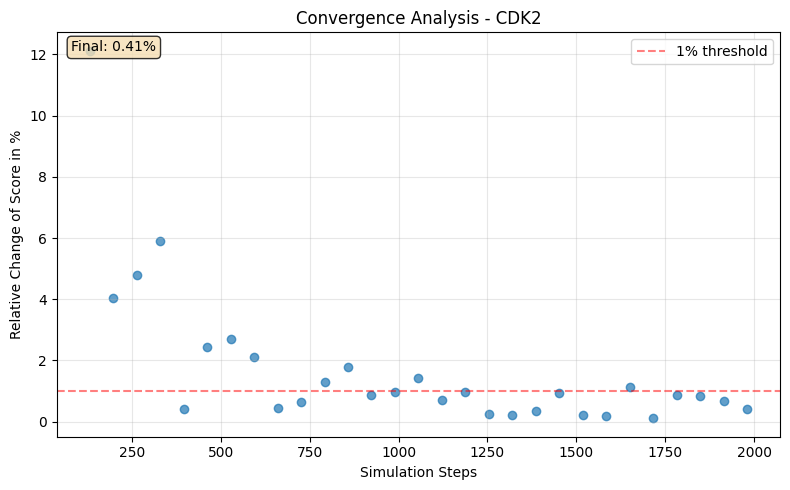

[0.04795205 0.45154845 0.33266733 0.5044955  0.44855145 1.
 0.6003996  0.59340659 0.09390609 0.         0.         0.94805195
 0.47152847]


In [41]:
# initialize the steady state calculator
calc = BNMPy.SteadyStateCalculator(pbn)
# set the experimental conditions
calc.set_experimental_conditions(stimuli=['EGFR'],inhibitors=['PIK3CA'])
# compute the steady state
steady_state,convergence_info = calc.compute_steady_state(
    method='monte_carlo',
    n_runs=3,
    n_steps=2000,
    p_noise=0.05,
    analyze_convergence=True,
    output_node='CDK2')
print(steady_state)

### Run optimization

In [51]:
# Configure optimizer
config = {
    'pso_params': {
        'n_particles': 100,
        'iters': 100,
        'options': {
            'c1': 0.5, # Cognitive parameter
            'c2': 0.3, # Social parameter
            'w': 0.9 # Inertia weight
        },
        'ftol': -1, # disable early stopping
        'ftol_iter': 5
    },
    'steady_state': {
        'method': 'monte_carlo',
            'monte_carlo_params': {
                'n_runs': 3,
                'n_steps': 2000,
                'p_noise': 0.05
            }
    },
    'max_try': 2,  # Maximum number of attempts if optimization fails
    'success_threshold': 0.02, # threshold for accepting fit,
    'display_rules_every': 0  # Display optimized rules every n iterations (0 = disabled)
}

In [53]:
optimizer = Optimizer.ParameterOptimizer(
    pbn,
    data_example_file, 
    config=config, 
    nodes_to_optimize=["AKT1","MAP2K1"],  # optimize the affected nodes
    verbose=False)

# Run optimization
result = optimizer.optimize(method='particle_swarm')

2025-07-24 23:23:33,073 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Optimization attempt 1/2
Running PSO optimization...




pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.000797
2025-07-25 01:52:08,042 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0007965736195206727, best pos: [0.79296874 0.29104758 0.33084707 0.52856303]



--- Optimization finished. Best MSE found: 0.000797 ---

--- Optimized PBN Rules ---
AKT1 = !CASP3 & !PTEN & ( PDPK1 | PIK3CA ), 0.7315
AKT1 = PIK3CA & !PTEN, 0.2685
CASP3 = !AKT1 & TP53, 1.0000
CDK2 = !TP53 & ( AKT1 | MAPK1 ), 1.0000
DNA_DAMAGE = DNA_DAMAGE, 1.0000
EGF = EGF, 1.0000
EGFR = EGF, 1.0000
MAP2K1 = !MAPK1 & ( MAP2K1 | PDPK1 ), 0.3850
MAP2K1 = EGFR, 0.6150
MAPK1 = MAP2K1, 1.0000
MDM2 = AKT1, 1.0000
PDPK1 = PDPK1, 1.0000
PIK3CA = EGFR | MAPK1, 1.0000
PTEN = !PIK3CA, 1.0000
TP53 = DNA_DAMAGE & !MDM2, 1.0000
---------------------------



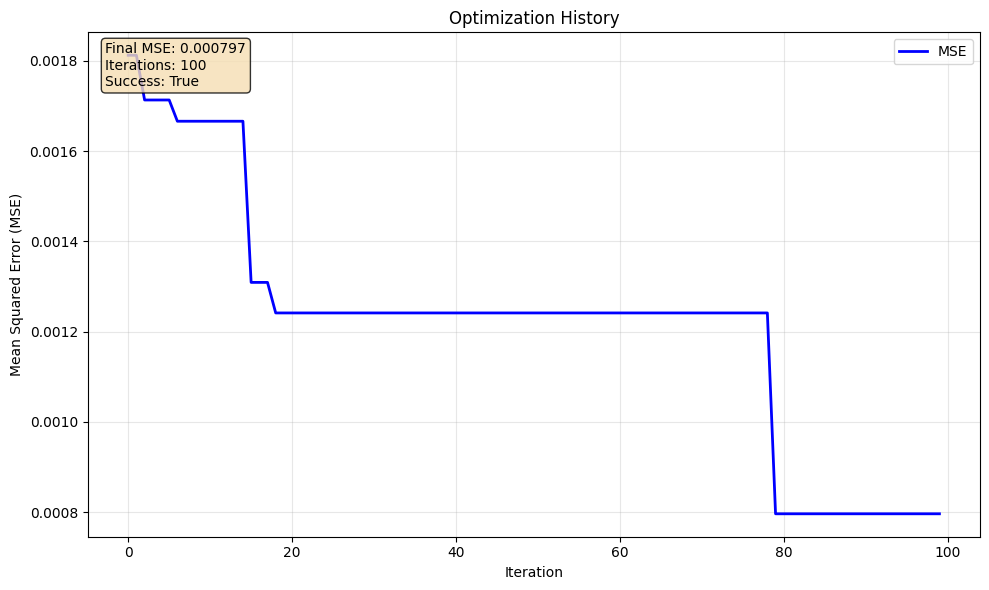

In [54]:
optimizer.plot_optimization_history(result)

In [55]:
# Configure optimizer
config = {
    'de_params': {
        'strategy': 'best1bin',
        'maxiter': 100,
        'popsize': 30,
        'tol': 0.0001, 
        'atol': 0,
        'mutation': (0.5, 1),
        'recombination': 0.7,
        'seed': 99,
        'disp': False,
        'init': 'sobol',
        'updating': 'deferred',
        'workers': -1,
        'early_stopping': False
    },
    'steady_state': {
        'method': 'monte_carlo',
            'monte_carlo_params': {
                'n_runs': 3,
                'n_steps': 2000,
                'p_noise': 0.05
            }
    },
    'max_try': 2,  # Maximum number of attempts if optimization fails
    'success_threshold': 0.01, # threshold for accepting fit,
    'display_rules_every': 0  # Display optimized rules every n iterations (0 = disabled)
}

optimizer_de = Optimizer.ParameterOptimizer(
    pbn,
    data_example_file, 
    config=config, 
    nodes_to_optimize=["AKT1","MAP2K1"], 
    verbose=False)

# Run optimization
result_de = optimizer_de.optimize(method='differential_evolution')


Optimization attempt 1/2
Running DE optimization...


[██████████████████████████████] 100.0% | Iter: 100/100 | Best MSE: 0.002207 | Conv: 0.0003

--- Optimization finished. Best MSE found: 0.001414 ---

--- Optimized PBN Rules ---
AKT1 = !CASP3 & !PTEN & ( PDPK1 | PIK3CA ), 0.7408
AKT1 = PIK3CA & !PTEN, 0.2592
CASP3 = !AKT1 & TP53, 1.0000
CDK2 = !TP53 & ( AKT1 | MAPK1 ), 1.0000
DNA_DAMAGE = DNA_DAMAGE, 1.0000
EGF = EGF, 1.0000
EGFR = EGF, 1.0000
MAP2K1 = !MAPK1 & ( MAP2K1 | PDPK1 ), 0.4409
MAP2K1 = EGFR, 0.5591
MAPK1 = MAP2K1, 1.0000
MDM2 = AKT1, 1.0000
PDPK1 = PDPK1, 1.0000
PIK3CA = EGFR | MAPK1, 1.0000
PTEN = !PIK3CA, 1.0000
TP53 = DNA_DAMAGE & !MDM2, 1.0000
---------------------------



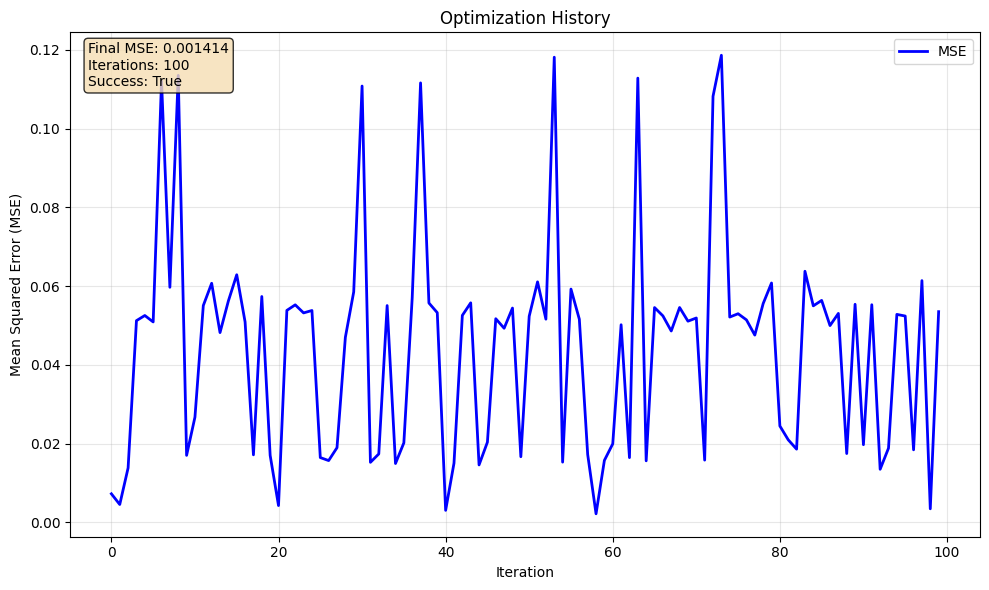

In [56]:
optimizer_de.plot_optimization_history(result_de)

## Evaluate the optimized network

Simulating optimized model on all experimental conditions...
  Experiment 1: 5 nodes simulated
  Experiment 2: 5 nodes simulated
  Experiment 3: 5 nodes simulated
  Experiment 4: 5 nodes simulated
  Experiment 5: 5 nodes simulated
  Experiment 6: 5 nodes simulated
  Experiment 7: 5 nodes simulated
  Experiment 8: 5 nodes simulated
  Experiment 9: 5 nodes simulated
  Experiment 10: 5 nodes simulated
Simulation completed: 50 data points
Plot saved to files/PBN_evaluation_results/prediction_vs_experimental.png
Residual plot saved to files/PBN_evaluation_results/residual_analysis.png
Evaluation report saved to files/PBN_evaluation_results/evaluation_report.txt
Results exported to files/PBN_evaluation_results/detailed_results.csv


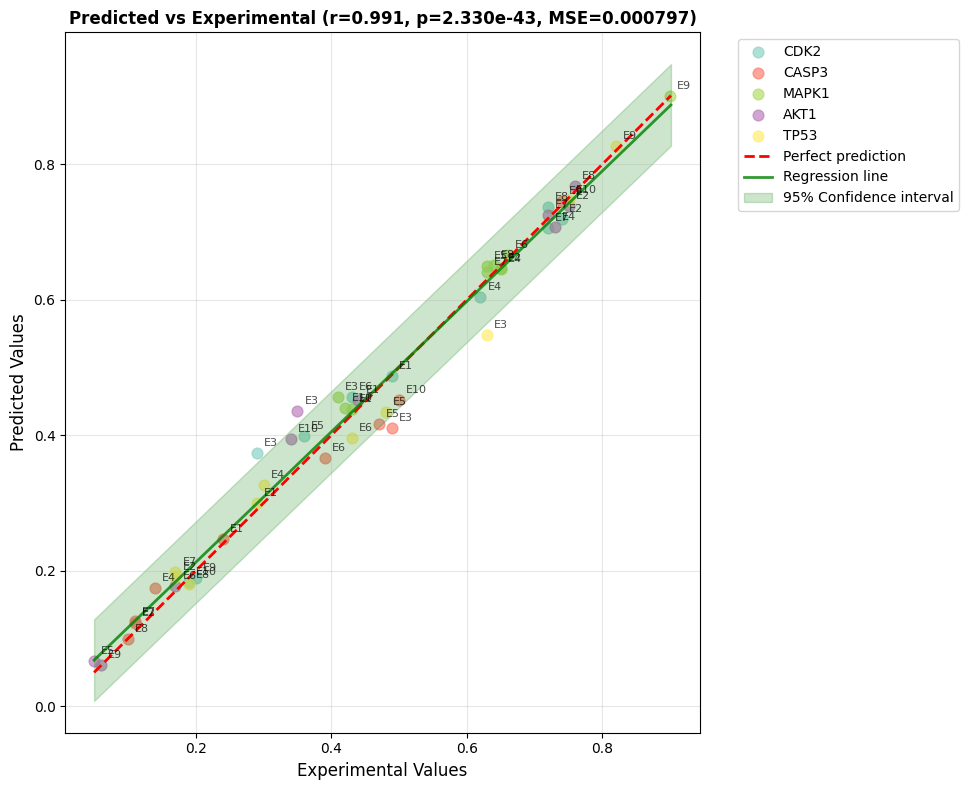

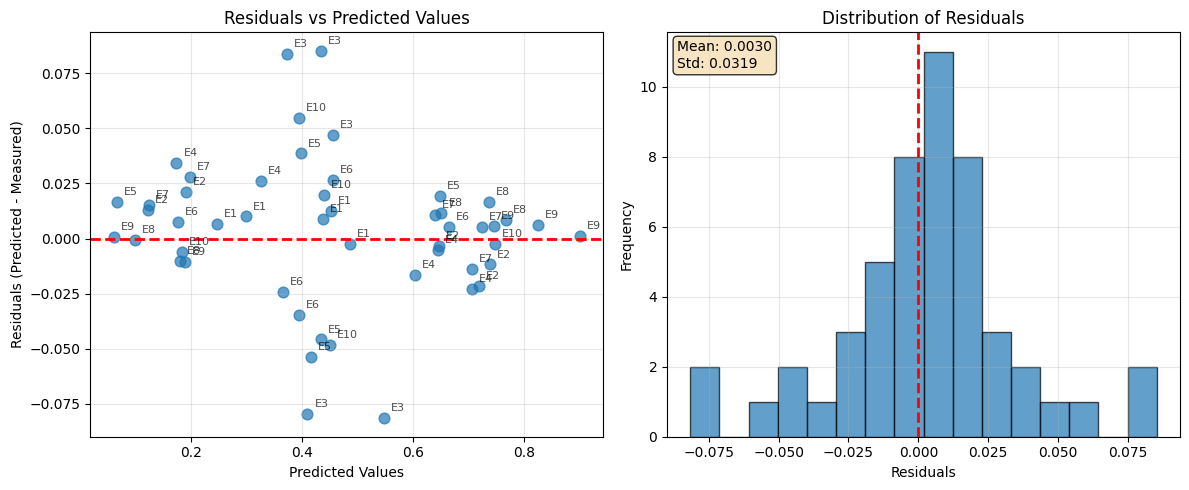

In [59]:
evaluator = Optimizer.evaluate_optimization_result(
    result, 
    optimizer, 
    output_dir="files/PBN_evaluation_results",
    save=True,
    detailed=True
)

## Simulate the optimized network

In [61]:
pbn_optimized = optimizer.get_optimized_pbn(result)
BNMPy.vis_network(pbn_optimized,"files/OptimizedPBN.html",interactive=True,measured_nodes=measured_nodes,perturbed_nodes=perturbed_nodes)

Network visualization saved to files/OptimizedPBN.html


In [91]:
import pandas as pd
import numpy as np
import itertools

perturbation_genes = ['PIK3CA','PDPK1','MAP2K1','MDM2']
stimuli_genes = ['EGF','DNA_DAMAGE']
pertubations = []
for r in range(1, len(perturbation_genes)+1):
    for combo in itertools.combinations(perturbation_genes, r):
        pertubations.append(','.join(combo))
stimuli = []
for r in range(1, len(stimuli_genes)+1):
    for combo in itertools.combinations(stimuli_genes, r):
        stimuli.append(','.join(combo))

df_results = pd.DataFrame()
for stimulus in stimuli:
    for pertubation in pertubations:
        calc = SteadyStateCalculator(pbn_optimized)
        calc.set_experimental_conditions(stimuli=[stimulus],inhibitors=[pertubation])
        steady_state = calc.compute_steady_state(
            method='monte_carlo',
            n_runs=3,
            n_steps=1000,
            p_noise=0.05)
        conditions = [f"Stimulus:{stimulus}; Inhibitor:{pertubation}"]
        df_steady_state = pd.DataFrame(steady_state,index=pbn_optimized.nodeDict.keys(),columns=conditions).T
        df_results = pd.concat([df_results,df_steady_state])
df_results

,AKT1,CASP3,CDK2,DNA_DAMAGE,EGF,EGFR,MAP2K1,MAPK1,MDM2,PDPK1,PIK3CA,PTEN,TP53
Stimulus:EGF; Inhibitor:PIK3CA,0.597472,0.070526,0.765802,0.0,1.0,0.945442,0.652029,0.634731,0.582834,0.000000,0.666667,0.363273,0.053227
Stimulus:EGF; Inhibitor:PDPK1,0.773786,0.063207,0.842315,0.0,1.0,0.947438,0.652029,0.641384,0.750499,0.000000,0.941450,0.090486,0.053892
Stimulus:EGF; Inhibitor:MAP2K1,0.069860,0.351297,0.591484,0.0,1.0,0.946108,0.666667,0.906188,0.660679,0.121756,0.666667,0.946108,0.347971
Stimulus:EGF; Inhibitor:MDM2,0.786427,0.060546,0.837658,0.0,1.0,0.951430,0.640719,0.624085,0.333333,0.000000,0.943446,0.102462,0.049235
"Stimulus:EGF; Inhibitor:PIK3CA,PDPK1",0.773786,0.070526,0.821025,0.0,1.0,0.952096,0.639388,0.624085,0.746507,0.000000,0.940120,0.101796,0.045243
"Stimulus:EGF; Inhibitor:PIK3CA,MAP2K1",0.781770,0.058550,0.844311,0.0,1.0,0.947438,0.632069,0.618097,0.754491,0.000000,0.934797,0.103127,0.038589
"Stimulus:EGF; Inhibitor:PIK3CA,MDM2",0.762475,0.055888,0.838989,0.0,1.0,0.953426,0.642049,0.630739,0.739854,0.000000,0.931470,0.113772,0.044578
"Stimulus:EGF; Inhibitor:PDPK1,MAP2K1",0.757818,0.058550,0.824351,0.0,1.0,0.952096,0.653360,0.634731,0.733866,0.000000,0.934797,0.109780,0.060546
"Stimulus:EGF; Inhibitor:PDPK1,MDM2",0.759814,0.068530,0.827013,0.0,1.0,0.947438,0.650033,0.638057,0.744511,0.000000,0.939454,0.110446,0.043912
"Stimulus:EGF; Inhibitor:MAP2K1,MDM2",0.765802,0.057219,0.821690,0.0,1.0,0.961411,0.654025,0.644045,0.738523,0.000000,0.929474,0.107784,0.053227


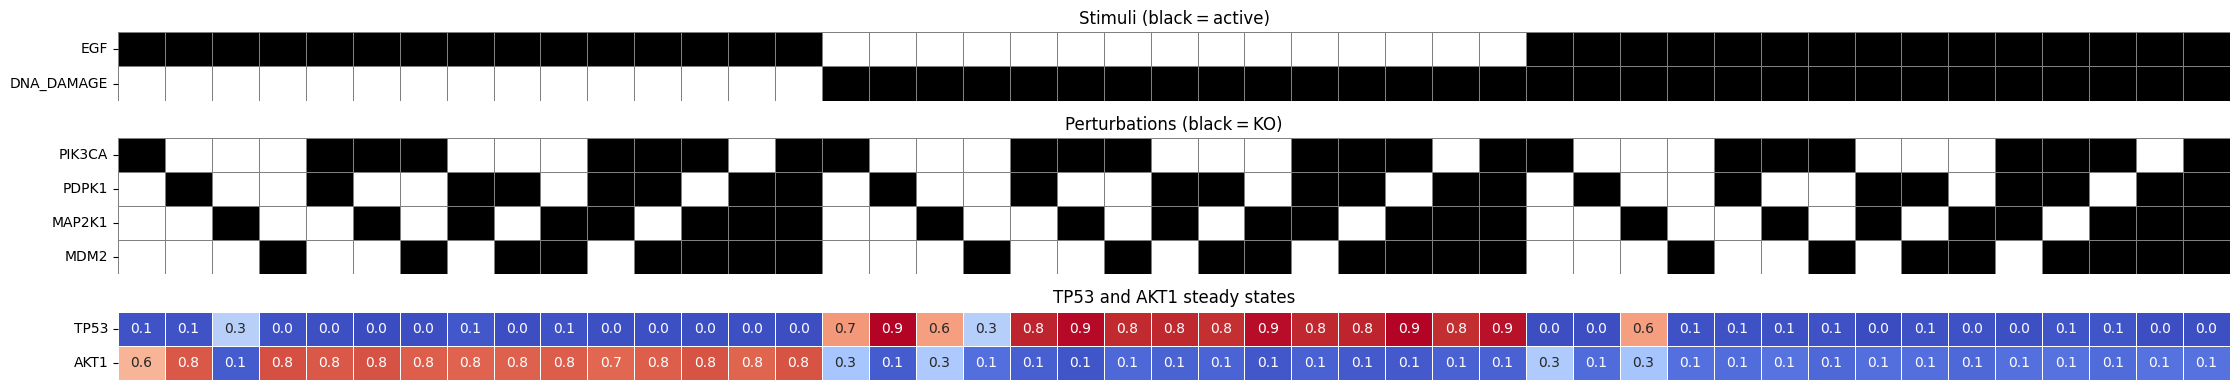

In [102]:
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

response_genes     = ['TP53', 'AKT1']

# build binary matrix from index strings
conditions = df_results.index.astype(str)
stimuli_block  = pd.DataFrame(0, index=stimuli_genes,      columns=conditions, dtype=int)
perturb_block  = pd.DataFrame(0, index=perturbation_genes, columns=conditions, dtype=int)
for cond in conditions:
    m_stim = re.search(r"Stimulus:([^;]+)", cond)
    m_inhib = re.search(r"Inhibitor:([^;]+)", cond)
    if m_stim:
        for g in [x.strip() for x in m_stim.group(1).split(',') if x.strip().lower() not in ['none', '']]:
            if g in stimuli_block.index:        stimuli_block.loc[g, cond] = 1
    if m_inhib:
        for g in [x.strip() for x in m_inhib.group(1).split(',') if x.strip().lower() not in ['none', '']]:
            if g in perturb_block.index:        perturb_block.loc[g, cond] = 1

response_block = df_results[response_genes].T

bw   = ListedColormap(['white', 'black'])
heat = sns.color_palette('coolwarm', as_cmap=True)
vmin, vmax = response_block.values.min(), response_block.values.max()

heights = [len(stimuli_block), len(perturb_block), len(response_block)]
fig, (ax_stim, ax_pert, ax_resp) = plt.subplots(
    3, 1,
    figsize=(0.5 * df_results.shape[0], 0.5 * sum(heights)),
    sharex=True,
    gridspec_kw={'height_ratios': heights}
)

sns.heatmap(stimuli_block, cmap=bw, vmin=0, vmax=1, ax=ax_stim,
            cbar=False, linewidths=.5, linecolor='grey')
ax_stim.set_title('Stimuli (black = active)')
ax_stim.set_ylabel('')
ax_stim.set_xticks([])
ax_stim.set_yticklabels(ax_stim.get_yticklabels(), rotation=0)

sns.heatmap(perturb_block, cmap=bw, vmin=0, vmax=1, ax=ax_pert,
            cbar=False, linewidths=.5, linecolor='grey')
ax_pert.set_title('Perturbations (black = KO)')
ax_pert.set_ylabel('')
ax_pert.set_xticks([])
ax_pert.set_yticklabels(ax_pert.get_yticklabels(), rotation=0)

sns.heatmap(response_block, cmap=heat, vmin=vmin, vmax=vmax, ax=ax_resp,
            cbar=False, linewidths=.5, linecolor='white', annot=True, fmt='.1f')
ax_resp.set_title('TP53 and AKT1 steady states')
ax_resp.set_ylabel('')
ax_resp.set_xlabel('')
ax_resp.set_xticks([])
ax_resp.set_yticklabels(ax_resp.get_yticklabels(), rotation=0)

for ax in (ax_stim, ax_pert, ax_resp):
    ax.tick_params(axis='x', rotation=45, labelsize=8)

plt.tight_layout()
plt.show()

# Generate synthetic data

In [48]:
import sys
import pandas as pd
import numpy as np
sys.path.append('./src')
import BNMPy
import Optimizer

In [50]:
pbn_hypothesis = BNMPy.load_pbn_from_string(
"""
AKT1 = !CASP3 & !PTEN & ( PDPK1 | PIK3CA ), 0.7
AKT1 = PIK3CA & !PTEN, 0.3
CASP3 = !AKT1 & TP53, 1.0
CDK2 = !TP53 & ( AKT1 | MAPK1 ), 1.0
DNA_DAMAGE = DNA_DAMAGE, 1.0
EGF = EGF, 1.0
EGFR = EGF, 1.0
MAP2K1 = !MAPK1 & ( MAP2K1 | PDPK1 ), 0.4
MAP2K1 = EGFR, 0.6
MAPK1 = MAP2K1, 1.0
MDM2 = AKT1, 1.0
PDPK1 = PDPK1, 1.0
PIK3CA = EGFR | MAPK1, 1.0
PTEN = !PIK3CA, 1.0
TP53 = DNA_DAMAGE & !MDM2, 1.0
"""
)
config = {
    'steady_state': {
        'method': 'monte_carlo',
            'monte_carlo_params': {
                'n_runs': 3,
                'n_steps': 2000,
                'p_noise': 0.05
            }
    }
}
Optimizer.generate_experiments(pbn_hypothesis,'files/experiments_blank.csv',config, 'files/experiments_example.csv', 2)

No initial state provided, using a random initial state
PBN loaded successfully. There are 13 genes in the network.
Generated experiment results saved to: files/experiments_example_test.csv


,Experiments,Stimuli,Stimuli_efficacy,Inhibitors,Inhibitors_efficacy,Measured_nodes,Measured_values,Predicted_values
0,1,,,,,"AKT1,MAPK1,TP53,CASP3,CDK2","0.05,0.05,0.05,0.05,0.05","0.44,0.43,0.29,0.24,0.49"
1,2,EGF,1.0,,,"AKT1,MAPK1,TP53,CASP3,CDK2","0.9,0.85,0.05,0.05,0.9","0.75,0.65,0.17,0.11,0.74"
2,3,DNA_DAMAGE,1.0,,,"AKT1,MAPK1,TP53,CASP3,CDK2","0.1,0.15,0.9,0.85,0.1","0.35,0.41,0.63,0.49,0.29"
3,4,"EGF,DNA_DAMAGE","1.0,1.0",,,"AKT1,MAPK1,TP53,CASP3,CDK2","0.75,0.7,0.4,0.3,0.6","0.73,0.65,0.3,0.14,0.62"
4,5,EGF,1.0,PIK3CA,1.0,"AKT1,MAPK1,TP53,CASP3,CDK2","0.3,0.8,0.1,0.15,0.45","0.05,0.63,0.48,0.47,0.36"
5,6,EGF,1.0,PIK3CA,0.7,"AKT1,MAPK1,TP53,CASP3,CDK2","0.25,0.78,0.12,0.2,0.4","0.17,0.66,0.43,0.39,0.43"
6,7,EGF,1.0,PDPK1,1.0,"AKT1,MAPK1,TP53,CASP3,CDK2","0.25,0.78,0.12,0.2,0.4","0.72,0.63,0.17,0.11,0.72"
7,8,EGF,1.0,PDPK1,0.5,"AKT1,MAPK1,TP53,CASP3,CDK2","0.25,0.78,0.12,0.2,0.4","0.76,0.64,0.19,0.1,0.72"
8,9,EGF,1.0,MAP2K1,1.0,"AKT1,MAPK1,TP53,CASP3,CDK2","0.88,0.25,0.06,0.05,0.55","0.06,0.9,0.82,0.74,0.2"
9,10,DNA_DAMAGE,1.0,MDM2,0.8,"AKT1,MAPK1,TP53,CASP3,CDK2","0.08,0.1,1.0,0.95,0.05","0.34,0.42,0.75,0.5,0.19"


# Test

In [23]:
from BNMPy.BMatrix import get_upstream_genes
get_upstream_genes(["C = A | B"])

['A B']

In [33]:
import importlib
importlib.reload(BNMPy.model_parser)
from BNMPy.model_parser import extend_networks
extended_network_string = extend_networks(compressed_network, KG, ['PDPK1'], prob=0.1)
print("\n")
print(extended_network_string)

Nodes affected: ['AKT1', 'MAP2K1', 'PDPK1']

Gene: AKT1
  Original rule: PIK3CA & !PTEN
  Added rule: !CASP3 & !PTEN & ( PDPK1 | PIK3CA ), 0.1

Gene: MAP2K1
  Original rule: RAF1
  Added rule: !MAPK1 & ( MAP2K1 | PDPK1 ), 0.1

Gene: PDPK1
  Not present in original network)
  Added rule: PDPK1, 1


AKT1 = !CASP3 & !PTEN & ( PDPK1 | PIK3CA ), 0.1
AKT1 = PIK3CA & !PTEN, 0.9
CASP3 = !AKT1 & TP53, 1.0
CDK2 = !TP53 & ( AKT1 | MAPK1 ), 1.0
DNA_DAMAGE = DNA_DAMAGE, 1.0
EGF = EGF, 1.0
EGFR = EGF, 1.0
KRAS = EGFR, 1.0
MAP2K1 = !MAPK1 & ( MAP2K1 | PDPK1 ), 0.1
MAP2K1 = RAF1, 0.9
MAPK1 = MAP2K1, 1.0
MDM2 = AKT1, 1.0
PDPK1 = PDPK1, 1.0
PIK3CA = EGFR | MAPK1, 1.0
PTEN = !PIK3CA, 1.0
TP53 = DNA_DAMAGE & !MDM2, 1.0
